In [1]:
from pprint import pprint
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import tensorflow as tf
import keras
from tensorflow.python.framework import ops
#from cnn_utils import *
import os
os.environ['CUDA_VISIBLE_DEVICES']='-1'
import deepdish.io as io
from keras.models import Sequential, Model
from keras.layers import Input, Add, Dense, Dropout, LeakyReLU
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import multi_gpu_model
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_curve, auc

/home/debo/env2/local/lib/python2.7/site-packages/h5py/__init__.py:36: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._conv import register_converters as _register_converters
/home/debo/env2/local/lib/python2.7/site-packages/h5py/__init__.py:45: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import h5a, h5d, h5ds, h5f, h5fd, h5g, h5r, h5s, h5t, h5p, h5z
/home/debo/env2/local/lib/python2.7/site-packages/h5py/_hl/group.py:22: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .. import h5g, h5i, h5o, h5r, h5t, h5l, h5p
/home/debo/env2/local/lib/python2.7/site-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/home/debo/env2/local/lib/python2.7/site-packages/scipy/linalg/__init__.py:207: Runtim

In [2]:
#Loading data
data_sig_A = io.load(os.path.join('MEM-A-0500_unscaled_signal.h5'))
data_sig_B = io.load(os.path.join('MEM-B-0500_unscaled_signal.h5'))
data_sig_C = io.load(os.path.join('MEM-C-0500_unscaled_signal.h5'))
data_back_A = io.load(os.path.join('MEM-A-0500_unscaled_background.h5'))
data_back_B = io.load(os.path.join('MEM-B-0500_unscaled_background.h5'))
data_back_B.keys()

['y', 'X', 'bkg_llh']

In [6]:
#Assigning data
X_Big_train = data_sig_A['X']
target_BigSig_train = data_sig_A['signal_llh']
y_BigSig_train = data_sig_A['y']

X_Big_test = data_sig_B['X']
target_BigSig_test = data_sig_B['signal_llh']
y_BigSig_test = data_sig_B['y']

X_Big_valid = data_sig_C['X']
target_BigSig_valid = data_sig_C['signal_llh']
y_BigSig_valid = data_sig_C['y']

target_BigBack_train = data_back_A['bkg_llh']
y_BigBack_train = data_back_A['y']
target_BigBack_test = data_back_B['bkg_llh']
y_BigBack_test = data_back_B['y']

sig_to_backRatio_train = target_BigSig_train/target_BigBack_train
sig_to_backRatio_test = target_BigSig_test/target_BigBack_test

np.shape(y_BigSig_valid)
#print np.shape(target_BigSig_test)
#print np.shape(target_BigBack_test)
print np.shape(sig_to_backRatio_train)
print np.shape(sig_to_backRatio_test)

(3028985,)
(151449,)


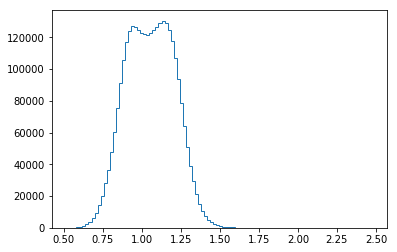

In [8]:
#_=plt.hist(target_BigSig_test[np.where(y_BigSig_test==1)],bins=100, histtype='step', label=' signal llh')
                           
#_=plt.hist(target_BigSig_test[np.where(y_BigSig_test==0)],bins=100, histtype='step', color= 'red')

#_=plt.hist(target_BigSig_train[np.where(y_BigSig_train==1)],bins=100, histtype='step', legend=' signal llh')
                           
#_=plt.hist(target_BigSig_train[np.where(y_BigSig_train==0)],bins=100, histtype='step', color= 'red')

_=plt.hist(sig_to_backRatio_train,bins=100, histtype='step')

#plt.legend(['training', 'validation'], loc='upper right')
#_=plt.hist(target_BigSig_test,bins=100)
#_=plt.hist(target_BigBack_test,bins=100)

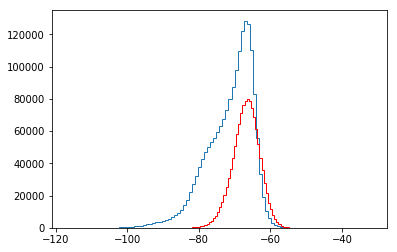

In [16]:
_=plt.hist(target_BigBack_train[np.where(y_BigBack_train==1)],bins=100, histtype='step')
_=plt.hist(target_BigBack_train[np.where(y_BigBack_train==0)],bins=100, color= 'red', histtype='step')

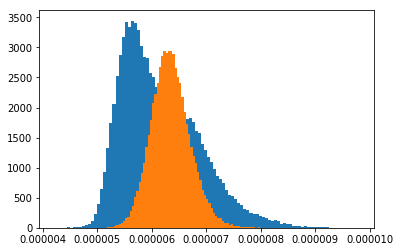

In [28]:
sig_percentage = target_BigSig_test[np.where(y_BigSig_test==1)]/np.sum(target_BigSig_test)
back_percentage = target_BigBack_test[np.where(y_BigBack_test==0)]/np.sum(target_BigBack_test)
_=plt.hist(sig_percentage,bins=100)
_=plt.hist(back_percentage,bins=100)

In [3]:
#Defining Sequential Model
def sequential_model():
    seqModel = Sequential()
    seqModel.add(Dense(32, input_dim=32, kernel_initializer='glorot_normal', activation='relu'))
    seqModel.add(Dense(12, kernel_initializer='glorot_normal', activation='relu'))
    seqModel.add(Dense(1, kernel_initializer='glorot_normal'))
    seqModel.compile(loss='mean_squared_error', optimizer='adam')
    return seqModel

In [6]:
#calling sequential model using standard scaler
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=sequential_model, epochs=20, batch_size=256, verbose=1)))
pipeline1 = Pipeline(estimators)
train=pipeline1.fit(X_Big_train,target_Big_train)
seqResult = pipeline1.predict(X_Big_test)
print("Standardized: %.2f (%.2f) MSE" % (seqResult.mean(), seqResult.std()))
print np.shape(seqResult), np.max(seqResult), np.min(seqResult)

Epoch 1/20
3028985/3028985 [==============================] - 17s 6us/step - loss: 141.3205
Epoch 2/20
3028985/3028985 [==============================] - 17s 6us/step - loss: 32.7917
Epoch 3/20
3028985/3028985 [==============================] - 17s 6us/step - loss: 30.3315
Epoch 4/20
3028985/3028985 [==============================] - 17s 6us/step - loss: 29.1945
Epoch 5/20
3028985/3028985 [==============================] - 17s 6us/step - loss: 28.2384
Epoch 6/20
3028985/3028985 [==============================] - 17s 6us/step - loss: 27.6191
Epoch 7/20
3028985/3028985 [==============================] - 17s 6us/step - loss: 27.1229
Epoch 8/20
3028985/3028985 [==============================] - 17s 6us/step - loss: 26.8382
Epoch 9/20
3028985/3028985 [==============================] - 17s 6us/step - loss: 26.6265
Epoch 10/20
3028985/3028985 [==============================] - 17s 6us/step - loss: 26.4312
Epoch 11/20
3028985/3028985 [==============================] - 17s 6us/step - loss: 26.2

In [7]:
print("Standardized: %.2f (%.2f) MSE" % (seqResult.mean(), seqResult.std()))
print np.shape(seqResult), np.max(seqResult), np.min(seqResult)

Standardized: -72.55 (7.22) MSE
(151449,) -52.62304 -106.59499


In [4]:
sti=sig_true_i=np.where(y_Big_test==1)[0]
bti=bkg_true_i=np.where(y_Big_test==0)[0]

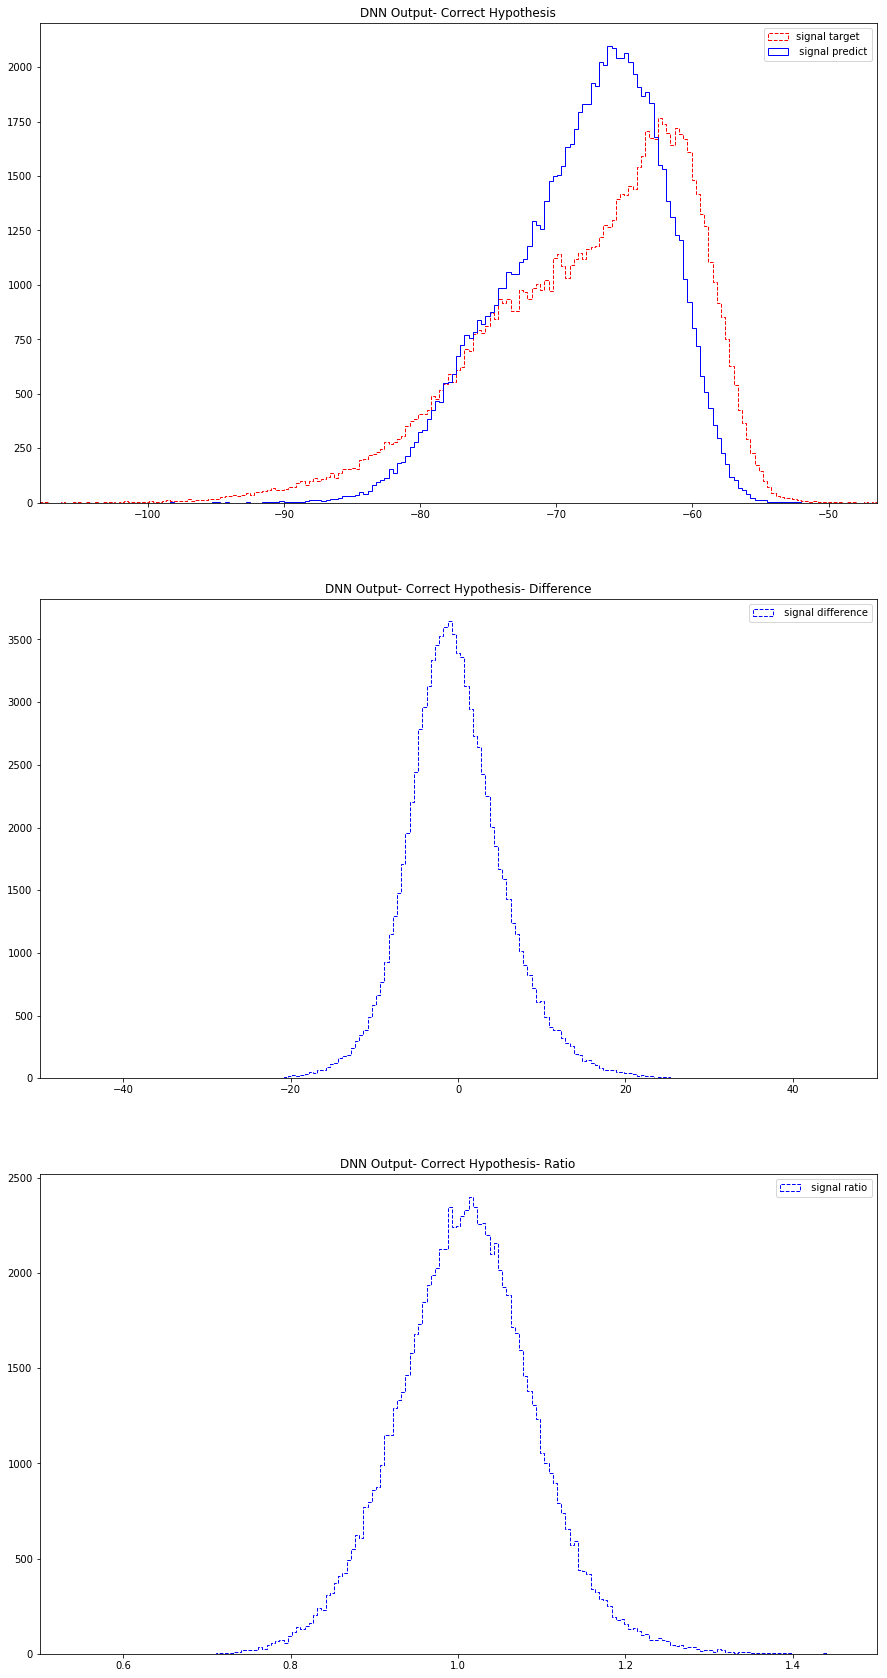

In [10]:
n_datasets = 1
n_plots = 3
n_bins = 200
f, axarr = plt.subplots(n_plots, n_datasets, sharex=False,
                            #gridspec_kw = {'height_ratios': [1,1,1,1]},
                            figsize=(15, 30),
                            squeeze=False)
plot_i=0
plot_title="DNN Output- Correct Hypothesis"

min_out=min(target_Big_test.min(),seqResult.min())
max_out=max(target_Big_test.max(),seqResult.max())
bins_out = np.linspace(min_out,max_out,n_bins)
axarr[plot_i,0].set_xlim((min_out,max_out))
        
axarr[plot_i,0].hist(target_Big_test[sti], color='red', histtype='step', bins=bins_out, linestyle='dashed', label='signal target')

#axarr[plot_i,0].hist(target[bti], color='red', histtype='step', bins=bins_out, linestyle='dashed', label=' background target')
axarr[plot_i,0].hist(seqResult[sti], color='blue', histtype='step', bins=bins_out, linestyle='solid', label=' signal predict') 
#axarr[plot_i,0].hist(predict[bti], color='red', histtype='step', bins=bins_out, linestyle='solid', label=' background predict')
        
axarr[plot_i][0].set_title(plot_title)
axarr[plot_i][0].legend(loc='best', ncol=1)

# Plot the Difference 
i=1
plot_i=0
plot_i+=1
plot_title="DNN Output- Correct Hypothesis- Difference"

diff_sig=seqResult[sti]-target_Big_test[sti]
#diff_bkg=predict[bti]-target[bti]
#print diff_sig
#print diff_bkg

min_diff=-50
max_diff=50
bins_diff = np.linspace(min_diff,max_diff,n_bins)

axarr[plot_i,0].set_xlim((min_diff,max_diff))
        
axarr[plot_i,0].hist(diff_sig, color='blue', histtype='step', bins=bins_diff, linestyle='dashed', label=' signal difference')
#axarr[plot_i,0].hist(diff_bkg[0], color='red', histtype='step',bins=bins_diff, linestyle='dashed', label=' background difference')
        
axarr[plot_i][0].set_title(plot_title)
axarr[plot_i][0].legend(loc='best', ncol=1)

# Plot the Ratio
plot_i+=1
plot_title="DNN Output- Correct Hypothesis- Ratio"

ratio_sig=seqResult[sti]/target_Big_test[sti]
#ratio_bkg=predict[bti]/target[bti]

min_ratio=0.5
max_ratio=1.5

bins_ratio = np.linspace(min_ratio,max_ratio,n_bins)

axarr[plot_i,0].set_xlim((min_ratio,max_ratio))
        
axarr[plot_i,0].hist(ratio_sig, color='blue', histtype='step', bins=bins_ratio, linestyle='dashed', label=' signal ratio')
#axarr[plot_i,0].hist(ratio_bkg[0], color='red', histtype='step',bins=bins_ratio, linestyle='dashed', label=' background ratio')
        
axarr[plot_i][0].set_title(plot_title)
axarr[plot_i][0].legend(loc='best', ncol=1)

In [5]:
##Defining Res_Net model
#def resnet_model(input_dim, output_dim, target):
def resnet_model(input_dim, output_dim):
    def _build_residual_block(x, apply_first=lambda x: x, apply_last=lambda x: x):
        indim = 40
        skip = apply_first(x)
        h = Dense(60)(x)
        h = Dropout(0.5)(LeakyReLU()(h))
        h = Dense(50)(x)
        h = Dropout(0.5)(LeakyReLU()(h))
        h = Dense(indim)(h)
        h = Dropout(0.5)(LeakyReLU()(h))
        h = apply_last(h)
        h = Dense(indim)(h)
        #Add()([X, X_shortcut])

        return LeakyReLU()(Add()([h, skip]))
    x = Input(shape=(input_dim, ))

    h = Dense(40)(x)
    h = Dropout(0.5)(LeakyReLU()(h))

    h = _build_residual_block(h)

    h = Dense(40)(x)
    h = Dropout(0.5)(LeakyReLU()(h))

    h = _build_residual_block(h)
    #h = _build_residual_block(h, apply_last=_build_residual_block)

    h = Dense(output_dim)(h)
    #y = Activation('sigmoid')(h)
    #if target == 'llhs':
    y = h
    #else:
    #y = Activation('sigmoid')(h) # soft and hard target are constrained between 0 and 1

    return Model(x, y)

In [6]:
model = resnet_model(input_dim =32, output_dim=1)
model.compile(loss='mean_squared_error', optimizer='adam')
sc_X = StandardScaler()
X_train1 = sc_X.fit_transform(X_Big_train)
X_test1 = sc_X.fit_transform(X_Big_test)
resTrain = model.fit(X_train1,target_Big_train, epochs=20, batch_size=256, verbose=1)
res_Result = model.predict(X_test1)
print np.shape(res_Result), np.max(res_Result), np.min(res_Result)

Epoch 1/20
3028985/3028985 [==============================] - 31s 10us/step - loss: 125.6927
Epoch 2/20
3028985/3028985 [==============================] - 31s 10us/step - loss: 37.9650
Epoch 3/20
3028985/3028985 [==============================] - 31s 10us/step - loss: 36.0428
Epoch 4/20
3028985/3028985 [==============================] - 31s 10us/step - loss: 35.3861
Epoch 5/20
3028985/3028985 [==============================] - 31s 10us/step - loss: 35.0106
Epoch 6/20
3028985/3028985 [==============================] - 30s 10us/step - loss: 34.7691
Epoch 7/20
3028985/3028985 [==============================] - 30s 10us/step - loss: 34.6437
Epoch 8/20
3028985/3028985 [==============================] - 31s 10us/step - loss: 34.5058
Epoch 9/20
3028985/3028985 [==============================] - 30s 10us/step - loss: 34.4053
Epoch 10/20
3028985/3028985 [==============================] - 30s 10us/step - loss: 34.2869
Epoch 11/20
3028985/3028985 [==============================] - 30s 10us/step -

In [25]:
resTrain.history.keys()

['loss']

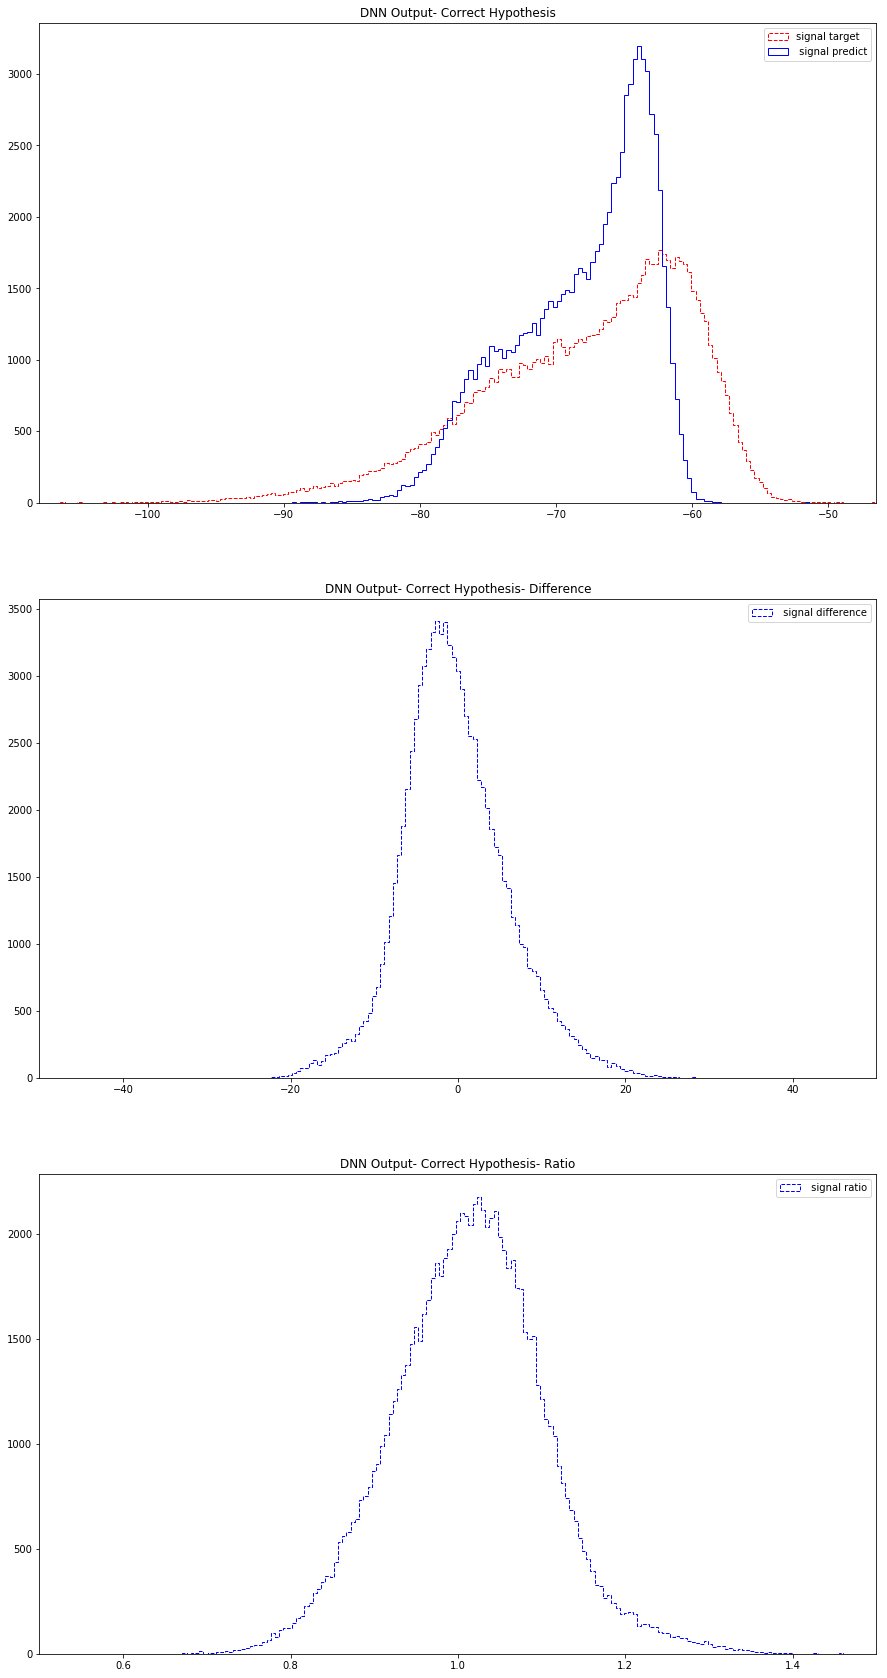

In [10]:
##For Res_Net
sti=sig_true_i=np.where(y_Big_test==1)[0]
bti=bkg_true_i=np.where(y_Big_test==0)[0]
n_datasets = 1
n_plots = 3
n_bins = 200
f1, axarr1 = plt.subplots(n_plots, n_datasets, sharex=False,
                            #gridspec_kw = {'height_ratios': [1,1,1,1]},
                            figsize=(15, 30),
                            squeeze=False)
plot_i1=0
plot_title="DNN Output- Correct Hypothesis"

min_out1=min(target_Big_test.min(),res_Result.min())
max_out1=max(target_Big_test.max(),res_Result.max())
bins_out1 = np.linspace(min_out1,max_out1,n_bins)
axarr1[plot_i1,0].set_xlim((min_out1,max_out1))
        
axarr1[plot_i1,0].hist(target_Big_test[sti], color='red', histtype='step', bins=bins_out1, linestyle='dashed', label='signal target')

#axarr[plot_i,0].hist(target[bti], color='red', histtype='step', bins=bins_out, linestyle='dashed', label=' background target')
axarr1[plot_i1,0].hist(res_Result[sti], color='blue', histtype='step', bins=bins_out1, linestyle='solid', label=' signal predict') 
#axarr[plot_i,0].hist(predict[bti], color='red', histtype='step', bins=bins_out, linestyle='solid', label=' background predict')
        
axarr1[plot_i1][0].set_title(plot_title)
axarr1[plot_i1][0].legend(loc='best', ncol=1)

#Plot the Difference 
#i=1
plot_i1=0
plot_i1+=1
plot_title="DNN Output- Correct Hypothesis- Difference"

#diff_sig1= 
#print(np.shape(res_Result[sti]))
#-target_Big_test[sti]
#print(np.shape(target_Big_test[sti]))
target = target_Big_test[sti]
target = target.reshape(90674,1)
diff_sig1 = res_Result[sti] - target
#diff_sig1= np.subtract(res_Result[sti],target_Big_test[sti])
min_diff1=-50
max_diff1=50
bins_diff1 = np.linspace(min_diff1,max_diff1,n_bins)

axarr1[plot_i1,0].set_xlim((min_diff1,max_diff1))
        
axarr1[plot_i1,0].hist(diff_sig1, color='blue', histtype='step', bins=bins_diff1, linestyle='dashed', label=' signal difference')
#axarr[plot_i,0].hist(diff_bkg[0], color='red', histtype='step',bins=bins_diff, linestyle='dashed', label=' background difference')
        
axarr1[plot_i1][0].set_title(plot_title)
axarr1[plot_i1][0].legend(loc='best', ncol=1)

# Plot the Ratio
plot_i1+=1
plot_title="DNN Output- Correct Hypothesis- Ratio"

ratio_sig=res_Result[sti]/target
#ratio_bkg=predict[bti]/target[bti]

min_ratio=0.5
max_ratio=1.5

bins_ratio = np.linspace(min_ratio,max_ratio,n_bins)

axarr1[plot_i1,0].set_xlim((min_ratio,max_ratio))
        
axarr1[plot_i1,0].hist(ratio_sig, color='blue', histtype='step', bins=bins_ratio, linestyle='dashed', label=' signal ratio')
#axarr[plot_i,0].hist(ratio_bkg[0], color='red', histtype='step',bins=bins_ratio, linestyle='dashed', label=' background ratio')
        
axarr1[plot_i1][0].set_title(plot_title)
axarr1[plot_i1][0].legend(loc='best', ncol=1)


In [39]:
X_pT = X_Big_train[:,0:8]

In [40]:
H_T = np.sum(X_pT,axis=1)

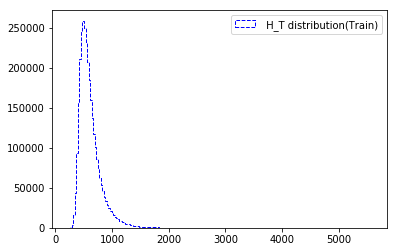

<Figure size 1440x5760 with 0 Axes>

In [43]:
n_bins = 200
min_ht = np.min(H_T)
max_ht = np.max(H_T)
bins_ht = np.linspace(min_ht,max_ht,n_bins)
plt.hist(H_T, color='blue',histtype='step', bins=bins_ht, linestyle='dashed', label=' H_T distribution(Train)')
plt.legend(loc='best', ncol=1)
plt.figure(figsize=(20,80))
plt.show()

In [44]:
X_pT_test = X_Big_test[:,0:8]

In [45]:
H_T_test = np.sum(X_pT_test,axis=1)

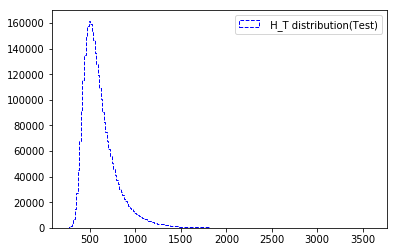

<Figure size 1440x5760 with 0 Axes>

In [46]:
n_bins = 200
min_ht = np.min(H_T_test)
max_ht = np.max(H_T_test)
bins_ht = np.linspace(min_ht,max_ht,n_bins)
plt.hist(H_T, color='blue',histtype='step', bins=bins_ht, linestyle='dashed', label=' H_T distribution(Test)')
plt.legend(loc='best', ncol=1)
plt.figure(figsize=(20,80))
plt.show()

In [11]:
#calling sequential model using standard scaler
estimators = []
estimators.append(('standardize', StandardScaler()))

estimators.append(('mlp', KerasRegressor(build_fn=sequential_model, epochs=50, batch_size=256, verbose=1)))
pipeline1 = Pipeline(estimators)
train=pipeline1.fit(X_Big_train,sig_to_backRatio_train)
seqResult = pipeline1.predict(X_Big_test)
print("Standardized: %.2f (%.2f) MSE" % (seqResult.mean(), seqResult.std()))
print np.shape(seqResult), np.max(seqResult), np.min(seqResult)

Epoch 1/50
3028985/3028985 [==============================] - 17s 6us/step - loss: 0.0230
Epoch 2/50
3028985/3028985 [==============================] - 17s 5us/step - loss: 0.0131
Epoch 3/50
3028985/3028985 [==============================] - 17s 6us/step - loss: 0.0127
Epoch 4/50
3028985/3028985 [==============================] - 17s 6us/step - loss: 0.0125
Epoch 5/50
3028985/3028985 [==============================] - 17s 6us/step - loss: 0.0124
Epoch 6/50
3028985/3028985 [==============================] - 17s 5us/step - loss: 0.0122
Epoch 7/50
3028985/3028985 [==============================] - 17s 6us/step - loss: 0.0120
Epoch 8/50
3028985/3028985 [==============================] - 17s 6us/step - loss: 0.0118
Epoch 9/50
3028985/3028985 [==============================] - 17s 6us/step - loss: 0.0116
Epoch 10/50
3028985/3028985 [==============================] - 17s 6us/step - loss: 0.0115
Epoch 11/50
3028985/3028985 [==============================] - 17s 6us/step - loss: 0.0114
Epoch 12

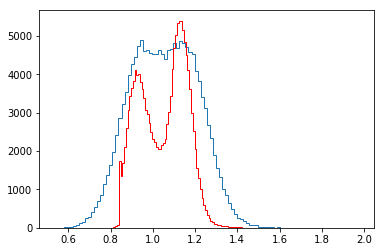

In [12]:
_=plt.hist(sig_to_backRatio_test,bins=100, histtype='step')
_=plt.hist(seqResult,bins=100, color= 'red', histtype='step')

In [13]:
#Defining Sequential Model
def sequential_model():
    seqModel = Sequential()
    seqModel.add(Dense(32, input_dim=32, kernel_initializer='glorot_normal', activation='relu'))
    seqModel.add(Dense(12, kernel_initializer='glorot_normal', activation='relu'))
    seqModel.add(Dense(1, kernel_initializer='glorot_normal',activation='sigmoid'))
    seqModel.compile(loss='mean_squared_error', optimizer='adam')
    return seqModel